# Import Lib

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import pickle
import warnings
import nltk 
from nltk.tokenize import RegexpTokenizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from nltk.stem.snowball import SnowballStemmer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, classification_report, precision_score,recall_score, accuracy_score, make_scorer, f1_score
from sklearn.model_selection import cross_val_score,train_test_split, cross_validate, cross_val_predict
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.svm import LinearSVC
from sklearn.decomposition import PCA
from pandarallel import pandarallel
from os import walk
from wordcloud import WordCloud, STOPWORDS
from time import time

# disable unuseful warnings
def warn(*args, **kwargs):
    pass

warnings.warn = warn

#warnings.filterwarnings('ignore', message="TOTAL NO. of ITERATIONS REACHED LIMIT")


# Import Data

In [2]:
# Read the urls database
urls_df = pd.read_csv(r'phishing_site_urls.csv')

# Rename the column
urls_df.rename(columns = {'URL':'Content'}, inplace = True)

# Change label "bad" in 0 and "good" in 1
urls_df.loc[urls_df["Label"]=="bad", "Label"]= 0
urls_df.loc[urls_df["Label"]=="good", "Label"]= 1
urls_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 549346 entries, 0 to 549345
Data columns (total 2 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   Content  549346 non-null  object
 1   Label    549346 non-null  object
dtypes: object(2)
memory usage: 8.4+ MB


In [3]:
label_counter = pd.DataFrame(urls_df.Label.value_counts())

In [4]:
print(label_counter.Label)
fig = px.bar(label_counter, x=label_counter.index, y=label_counter.Label)
fig.show()

1    392924
0    156422
Name: Label, dtype: int64


,Content,Label
14235,Subject: re : commodity logic\n what do you th...,1
7020,"Subject: re : greetings\n hi , mr . kaminski :...",1
20253,Subject: his 17 year old daughter . . . ( doll...,0
9353,Subject: unresolved issues for jan 1 .\n i thi...,1
10373,"Subject: shipper "" out "" - - red rock expansio...",1
30273,Subject: get the best price on your next car !...,0
10714,Subject: fw : lower colorado river authority\n...,1
12434,Subject: fw : csfb ipp weekly : dyn / ene deal...,1
15611,Subject: sean wells resume\n any interest ? ?\...,1
21888,Subject: let the euro make you money\n,0


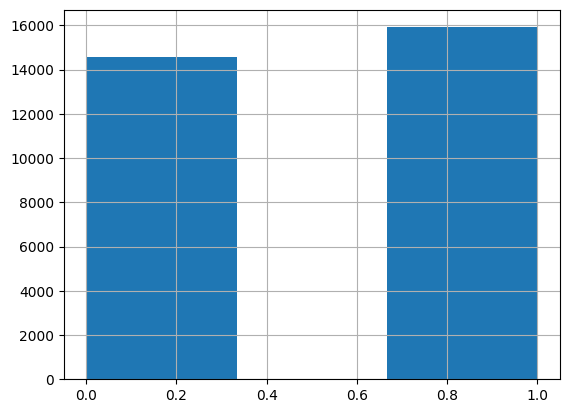

In [5]:
# Read the emails dataset
pathwalk = walk(r"enron-spam/")

allHamData, allSpamData = [], []
for root, dr, file in pathwalk:
    if 'ham' in str(file):
        for obj in file:
            with open(root + '/' + obj, encoding='latin1') as ip:
                allHamData.append(" ".join(ip.readlines()))

    elif 'spam' in str(file):
        for obj in file:
            with open(root + '/' + obj, encoding='latin1') as ip:
                allSpamData.append(" ".join(ip.readlines()))
                
# remove all redundant data
allHamData = list(set(allHamData))
allSpamData = list(set(allSpamData))

# merge it in a dataframe
hamPlusSpamData = allHamData + allSpamData

# Labels: "bad" = 0 and "good" = 1
labels = [1]*len(allHamData) + [0]*len(allSpamData)

emails_df = pd.DataFrame({"Content": hamPlusSpamData, "Label": labels})

# get an overview of the data
emails_df.Label.hist(bins=3)
emails_df.sample(10)

In [6]:
df = pd.concat([urls_df, emails_df], axis=0)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 579840 entries, 0 to 30493
Data columns (total 2 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   Content  579840 non-null  object
 1   Label    579840 non-null  object
dtypes: object(2)
memory usage: 13.3+ MB


In [7]:
label_counter = pd.DataFrame(df.Label.value_counts())
print(label_counter.Label)
fig = px.bar(label_counter, x=label_counter.index, y=label_counter.Label)
fig.show()

1    408834
0    171006
Name: Label, dtype: int64


### Visualization

In [8]:
bad_words = df[df.Label == 0]
good_words = df[df.Label == 1]
bad_words.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 171006 entries, 0 to 30493
Data columns (total 2 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   Content  171006 non-null  object
 1   Label    171006 non-null  object
dtypes: object(2)
memory usage: 3.9+ MB


In [9]:
good_words.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 408834 entries, 18231 to 15909
Data columns (total 2 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   Content  408834 non-null  object
 1   Label    408834 non-null  object
dtypes: object(2)
memory usage: 9.4+ MB


# Pipeline

In [10]:
stopwords = nltk.corpus.stopwords.words('english')
snow_stemmer = SnowballStemmer('english')

In [11]:
analyzer = CountVectorizer(stop_words = stopwords).build_analyzer()

In [12]:
def snowball_analyzer(doc):
    return [snow_stemmer.stem(w) for w in analyzer(doc)]

In [13]:
def print_metrics(results):
    metrics = ['accuracy','precision_ham', 'recall_ham','precision_spam', 'recall_spam']
    for metric in metrics:
        print(f'{metric:15}', np.round(results["test_"+metric].mean(),3), [np.round(elem,3) for elem in results["test_"+metric]])
    print()
    print(f'{"vocabulary size":15}', np.mean([len(results['estimator'][i][0].vocabulary_) for i in range(n_folds)]))
    print(f'{"fit_time":15}', np.round(results["fit_time"].mean()))
    print(f'{"score_time":15}', np.round(results["score_time"].mean()))

### Random Undersampling

In [14]:
# Separate the majority and minority classes
majority_class = df[df['Label'] == 1]
minority_class = df[df['Label'] == 0]

# Undersample the majority class
undersampled_majority_class = majority_class.sample(n=len(minority_class), random_state=42)

# Combine the undersampled majority class with the minority class
undersampled_df = pd.concat([undersampled_majority_class, minority_class])

# Shuffle the rows of the combined dataset
undersampled_df = undersampled_df.sample(frac=1, random_state=42)

# Reset the index
undersampled_df = undersampled_df.reset_index(drop=True)
undersampled_df.sample(10)


,Content,Label
163591,vpike.com/?d=1049759&s=OH&f=park,1
244561,canvilada.com/54fc3rc3fr,0
9578,youtube.com/watch?v=i300smFTanE,1
234553,media.ford.com/article_display.cfm?article_id=...,1
86003,rootsweb.ancestry.com/~misaghs/1951to1960.htm,1
270515,forum.worldstart.com/archive/index.php/t-10597...,1
25220,rldtmruliuen.work/information.cgi,0
195267,lyricsmode.com/lyrics/g/gwen_stefani/cool.html,1
278934,nsplucknow.com/images/client/fb/relogin/,0
134542,jhoward.fastmail.fm/,1


In [15]:
undersampled_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 342012 entries, 0 to 342011
Data columns (total 2 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   Content  342012 non-null  object
 1   Label    342012 non-null  object
dtypes: object(2)
memory usage: 5.2+ MB


In [16]:
under_label = undersampled_df.Label.values
under_label = under_label.astype('int')

# KFold cross_validate
n_folds = 10
kf = KFold(n_folds)

# LR Pipeline

Logistic Regression with TfidfVectorizer

In [17]:
start = time()
pipe = Pipeline([('vect', TfidfVectorizer(stop_words = stopwords)), ('clf', LogisticRegression())])
y_pred = cross_val_predict(pipe, undersampled_df.Content.values, under_label, cv=kf)
LR_tfidf = cross_validate(pipe,
                         undersampled_df.Content.values,
                         under_label,
                         scoring = {'precision_ham': make_scorer(precision_score,pos_label = 1),                         
                                    'precision_spam': make_scorer(precision_score,pos_label = 0),
                                    'recall_ham': make_scorer(recall_score,pos_label = 1),
                                    'recall_spam': make_scorer(recall_score,pos_label = 0),
                                    'accuracy': make_scorer(accuracy_score),
                                    'fscore_spam': make_scorer(f1_score,pos_label = 0),
                                    'fscore_ham': make_scorer(f1_score,pos_label = 1)},                         
                         return_estimator = True,
                         cv = kf,
                         n_jobs = 12) # Number of jobs to run in parallel. 
                                      # Training the estimator and computing the score are parallelized over the cross-validation splits.

print_metrics(LR_tfidf)

elapsed = time()-start
print(elapsed)

/home/giacomo/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/giacomo/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regres

accuracy        0.955 [0.955, 0.955, 0.954, 0.956, 0.955, 0.956, 0.955, 0.956, 0.955, 0.956]
precision_ham   0.94 [0.94, 0.94, 0.94, 0.942, 0.939, 0.941, 0.94, 0.939, 0.941, 0.942]
recall_ham      0.972 [0.972, 0.971, 0.969, 0.973, 0.972, 0.972, 0.973, 0.974, 0.971, 0.972]
precision_spam  0.971 [0.97, 0.97, 0.969, 0.972, 0.971, 0.971, 0.972, 0.973, 0.97, 0.971]
recall_spam     0.938 [0.937, 0.938, 0.94, 0.94, 0.938, 0.939, 0.938, 0.938, 0.938, 0.94]

vocabulary size 415120.9
fit_time        155.0
score_time      5.0
726.2524862289429



CLASSIFICATION REPORT

              precision    recall  f1-score   support

         Bad       0.97      0.94      0.95    171006
        Good       0.94      0.97      0.96    171006

    accuracy                           0.96    342012
   macro avg       0.96      0.96      0.96    342012
weighted avg       0.96      0.96      0.96    342012


CONFUSION MATRIX


<AxesSubplot: >

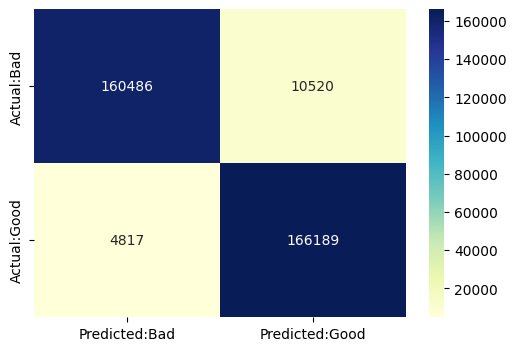

In [18]:
con_mat = pd.DataFrame(confusion_matrix(under_label, y_pred),
            columns = ['Predicted:Bad', 'Predicted:Good'],
            index = ['Actual:Bad', 'Actual:Good'])

print('\nCLASSIFICATION REPORT\n')
print(classification_report(under_label, y_pred,
                            target_names =['Bad','Good']))

print('\nCONFUSION MATRIX')
plt.figure(figsize= (6,4))
sns.heatmap(con_mat, annot = True,fmt='d',cmap="YlGnBu")

Logistic Regression with CountVectorizer

In [19]:
start = time()
pipe = Pipeline([('vect', CountVectorizer(stop_words = stopwords)), ('clf', LogisticRegression())])
y_pred = cross_val_predict(pipe, undersampled_df.Content.values, under_label, cv=kf)
LR_cvect = cross_validate(pipe,
                         undersampled_df.Content.values,
                         under_label,
                         scoring = {'precision_ham': make_scorer(precision_score,pos_label = 1),                         
                                    'precision_spam': make_scorer(precision_score,pos_label = 0),
                                    'recall_ham': make_scorer(recall_score,pos_label = 1),
                                    'recall_spam': make_scorer(recall_score,pos_label = 0),
                                    'accuracy': make_scorer(accuracy_score),
                                    'fscore_spam': make_scorer(f1_score,pos_label = 0),
                                    'fscore_ham': make_scorer(f1_score,pos_label = 1)},                         
                         return_estimator = True,
                         cv = kf,
                         n_jobs = 12) # Number of jobs to run in parallel. 
                                      # Training the estimator and computing the score are parallelized over the cross-validation splits.

print_metrics(LR_cvect)

elapsed = time()-start
print(elapsed)

/home/giacomo/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/giacomo/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regres

accuracy        0.959 [0.959, 0.959, 0.956, 0.961, 0.958, 0.957, 0.962, 0.959, 0.957, 0.958]
precision_ham   0.948 [0.947, 0.949, 0.948, 0.949, 0.947, 0.948, 0.949, 0.947, 0.949, 0.949]
recall_ham      0.97 [0.974, 0.97, 0.965, 0.974, 0.97, 0.968, 0.975, 0.971, 0.967, 0.969]
precision_spam  0.97 [0.972, 0.969, 0.965, 0.973, 0.969, 0.967, 0.974, 0.971, 0.966, 0.968]
recall_spam     0.947 [0.945, 0.948, 0.948, 0.947, 0.946, 0.947, 0.948, 0.947, 0.947, 0.948]

vocabulary size 415120.9
fit_time        98.0
score_time      2.0
512.4306418895721



CLASSIFICATION REPORT

              precision    recall  f1-score   support

         Bad       0.97      0.95      0.96    171006
        Good       0.95      0.97      0.96    171006

    accuracy                           0.96    342012
   macro avg       0.96      0.96      0.96    342012
weighted avg       0.96      0.96      0.96    342012


CONFUSION MATRIX


<AxesSubplot: >

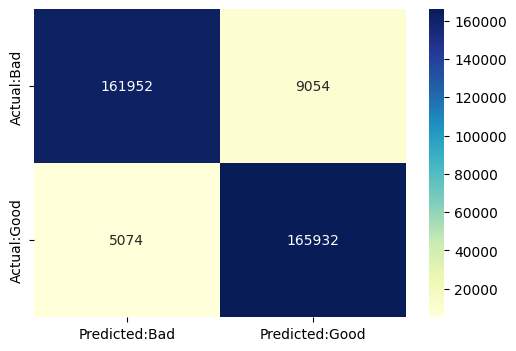

In [20]:
con_mat = pd.DataFrame(confusion_matrix(under_label, y_pred),
            columns = ['Predicted:Bad', 'Predicted:Good'],
            index = ['Actual:Bad', 'Actual:Good'])

print('\nCLASSIFICATION REPORT\n')
print(classification_report(under_label, y_pred,
                            target_names =['Bad','Good']))

print('\nCONFUSION MATRIX')
plt.figure(figsize= (6,4))
sns.heatmap(con_mat, annot = True,fmt='d',cmap="YlGnBu")

### Comparing Metrics with different Vectorizer
We compare the accuracy metric from LogisticRegression

In [21]:
metrics = pd.DataFrame({'LR_tfidf':LR_tfidf['test_accuracy'], 'LR_cvect': LR_cvect['test_accuracy']})
metrics

,LR_tfidf,LR_cvect
0,0.954535,0.959388
1,0.954506,0.958891
2,0.954358,0.956288
3,0.956317,0.960820
4,0.954826,0.957984
5,0.955586,0.957282
6,0.955294,0.961551
7,0.955586,0.958919
8,0.954767,0.957077
9,0.956171,0.958364


array([[<AxesSubplot: title={'center': 'LR_tfidf'}>,
        <AxesSubplot: title={'center': 'LR_cvect'}>, <AxesSubplot: >]],
      dtype=object)

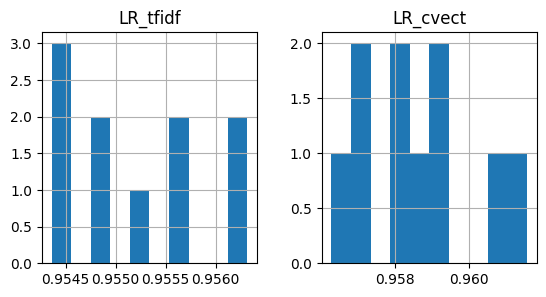

In [22]:
metrics.hist(layout = (1,3),figsize = (10,3))

<AxesSubplot: >

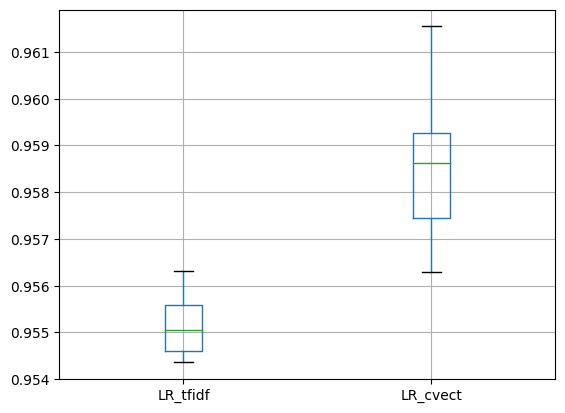

In [23]:
metrics.boxplot()

We compare the fscore_spam metric from LogisticRegression

In [24]:
metrics = pd.DataFrame({'LR_tfidf':LR_tfidf['test_fscore_spam'], 'LR_cvect': LR_cvect['test_fscore_spam']})
metrics

,LR_tfidf,LR_cvect
0,0.953391,0.958499
1,0.953646,0.958331
2,0.954079,0.956308
3,0.955578,0.960280
4,0.954199,0.957627
5,0.954866,0.956858
6,0.954547,0.961087
7,0.955050,0.958653
8,0.953667,0.956325
9,0.955303,0.957780


array([[<AxesSubplot: title={'center': 'LR_tfidf'}>,
        <AxesSubplot: title={'center': 'LR_cvect'}>, <AxesSubplot: >]],
      dtype=object)

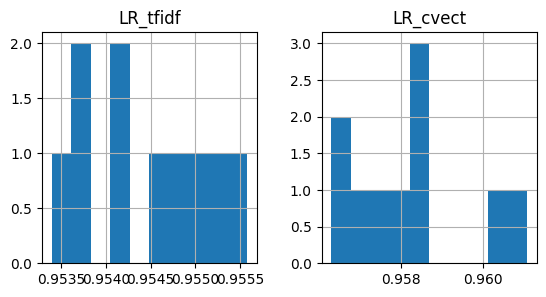

In [25]:
metrics.hist(layout = (1,3),figsize = (10,3))

<AxesSubplot: >

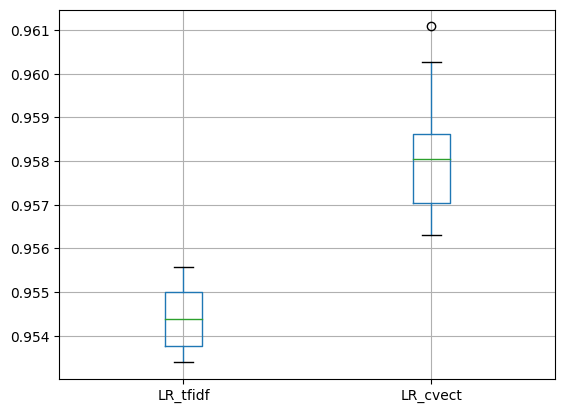

In [26]:
metrics.boxplot()

# SVC Pipeline

### SVC (with CountVectorizer)

In [27]:
start = time()
pipe = Pipeline([('vect', CountVectorizer(stop_words = stopwords)), ('clf', LinearSVC())])
y_pred = cross_val_predict(pipe, undersampled_df.Content.values, under_label, cv=kf)
SVC_cvect = cross_validate(pipe,
                         undersampled_df.Content.values,
                         under_label,
                         scoring = {'precision_ham': make_scorer(precision_score,pos_label = 1),                         
                                    'precision_spam': make_scorer(precision_score,pos_label = 0),
                                    'recall_ham': make_scorer(recall_score,pos_label = 1),
                                    'recall_spam': make_scorer(recall_score,pos_label = 0),
                                    'accuracy': make_scorer(accuracy_score),
                                    'fscore_spam': make_scorer(f1_score,pos_label = 0),
                                    'fscore_ham': make_scorer(f1_score,pos_label = 1)},                    
                         return_estimator = True,
                         cv = kf,
                         n_jobs = 12) # Number of jobs to run in parallel. 
                                      # Training the estimator and computing the score are parallelized over the cross-validation splits.

print_metrics(SVC_cvect)

elapsed = time()-start
print(elapsed)

/home/giacomo/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/giacomo/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/giacomo/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/giacomo/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/giacomo/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/giacomo/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinea

accuracy        0.975 [0.976, 0.975, 0.975, 0.975, 0.975, 0.975, 0.976, 0.975, 0.976, 0.976]
precision_ham   0.97 [0.971, 0.971, 0.97, 0.97, 0.971, 0.97, 0.97, 0.968, 0.972, 0.972]
recall_ham      0.981 [0.982, 0.98, 0.98, 0.98, 0.98, 0.981, 0.982, 0.983, 0.981, 0.981]
precision_spam  0.981 [0.981, 0.98, 0.98, 0.98, 0.98, 0.981, 0.982, 0.983, 0.98, 0.98]
recall_spam     0.97 [0.97, 0.97, 0.97, 0.97, 0.971, 0.97, 0.97, 0.968, 0.971, 0.971]

vocabulary size 415120.9
fit_time        161.0
score_time      2.0
578.6235375404358



CLASSIFICATION REPORT

              precision    recall  f1-score   support

         Bad       0.98      0.97      0.98    171006
        Good       0.97      0.98      0.98    171006

    accuracy                           0.98    342012
   macro avg       0.98      0.98      0.98    342012
weighted avg       0.98      0.98      0.98    342012


CONFUSION MATRIX


<AxesSubplot: >

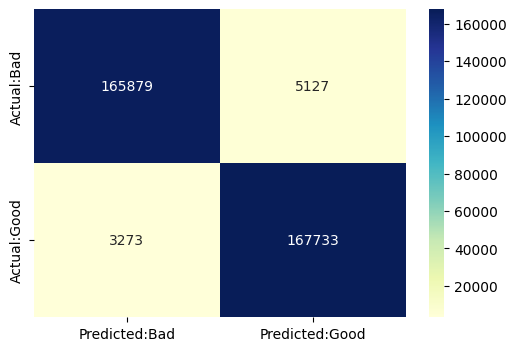

In [28]:
con_mat = pd.DataFrame(confusion_matrix(under_label, y_pred),
            columns = ['Predicted:Bad', 'Predicted:Good'],
            index = ['Actual:Bad', 'Actual:Good'])

print('\nCLASSIFICATION REPORT\n')
print(classification_report(under_label, y_pred,
                            target_names =['Bad','Good']))

print('\nCONFUSION MATRIX')
plt.figure(figsize= (6,4))
sns.heatmap(con_mat, annot = True,fmt='d',cmap="YlGnBu")

### SVC (with TfidfVectorizer)

In [29]:
start = time()
pipe = Pipeline([('vect', TfidfVectorizer(stop_words = stopwords)), ('clf', LinearSVC())])
y_pred = cross_val_predict(pipe, undersampled_df.Content.values, under_label, cv=kf)
SVC_tfidf = cross_validate(pipe,
                         undersampled_df.Content.values,
                         under_label,
                         scoring = {'precision_ham': make_scorer(precision_score,pos_label = 1),                         
                                    'precision_spam': make_scorer(precision_score,pos_label = 0),
                                    'recall_ham': make_scorer(recall_score,pos_label = 1),
                                    'recall_spam': make_scorer(recall_score,pos_label = 0),
                                    'accuracy': make_scorer(accuracy_score),
                                    'fscore_spam': make_scorer(f1_score,pos_label = 0),
                                    'fscore_ham': make_scorer(f1_score,pos_label = 1)},                    
                         return_estimator = True,
                         cv = kf,
                         n_jobs = 12) # Number of jobs to run in parallel. 
                                      # Training the estimator and computing the score are parallelized over the cross-validation splits.

print_metrics(SVC_tfidf)

elapsed = time()-start
print(elapsed)

accuracy        0.978 [0.978, 0.977, 0.977, 0.978, 0.978, 0.978, 0.978, 0.977, 0.977, 0.978]
precision_ham   0.972 [0.972, 0.973, 0.972, 0.973, 0.973, 0.972, 0.971, 0.969, 0.973, 0.973]
recall_ham      0.983 [0.984, 0.982, 0.982, 0.983, 0.983, 0.984, 0.984, 0.985, 0.982, 0.984]
precision_spam  0.983 [0.983, 0.982, 0.982, 0.983, 0.983, 0.984, 0.984, 0.985, 0.982, 0.984]
recall_spam     0.972 [0.971, 0.973, 0.972, 0.973, 0.973, 0.971, 0.971, 0.969, 0.972, 0.972]

vocabulary size 415120.9
fit_time        38.0
score_time      2.0
138.1027159690857



CLASSIFICATION REPORT

              precision    recall  f1-score   support

         Bad       0.98      0.97      0.98    171006
        Good       0.97      0.98      0.98    171006

    accuracy                           0.98    342012
   macro avg       0.98      0.98      0.98    342012
weighted avg       0.98      0.98      0.98    342012


CONFUSION MATRIX


<AxesSubplot: >

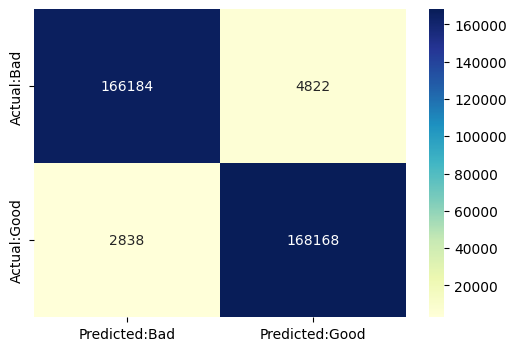

In [30]:
con_mat = pd.DataFrame(confusion_matrix(under_label, y_pred),
            columns = ['Predicted:Bad', 'Predicted:Good'],
            index = ['Actual:Bad', 'Actual:Good'])

print('\nCLASSIFICATION REPORT\n')
print(classification_report(under_label, y_pred,
                            target_names =['Bad','Good']))

print('\nCONFUSION MATRIX')
plt.figure(figsize= (6,4))
sns.heatmap(con_mat, annot = True,fmt='d',cmap="YlGnBu")

# LR vs SVC

### Comparing Metrics with different Models
We compare the fscore_spam metrics from LogisticRegression and LinearSVC
FScore

In [31]:
metrics = pd.DataFrame({'LR':LR_cvect['test_fscore_spam'], 'SVC': SVC_cvect['test_fscore_spam']})
metrics

,LR,SVC
0,0.958499,0.975530
1,0.958331,0.974884
2,0.956308,0.975155
3,0.960280,0.974605
4,0.957627,0.975417
5,0.956858,0.975085
6,0.961087,0.975787
7,0.958653,0.975440
8,0.956325,0.975542
9,0.957780,0.975673


array([[<AxesSubplot: title={'center': 'LR'}>,
        <AxesSubplot: title={'center': 'SVC'}>, <AxesSubplot: >]],
      dtype=object)

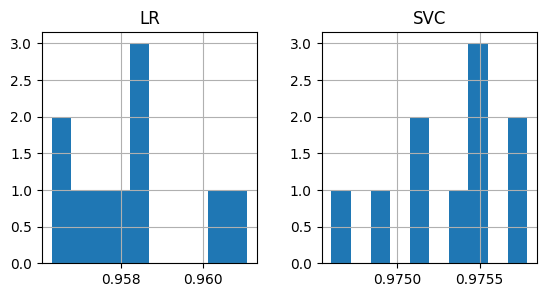

In [32]:
metrics.hist(layout = (1,3),figsize = (10,3))

<AxesSubplot: >

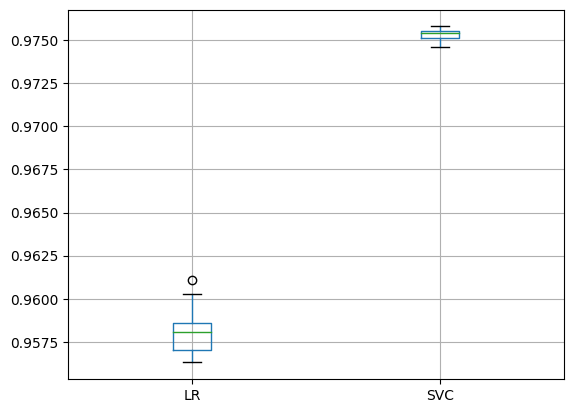

In [33]:
metrics.boxplot()

Accuracy metrics comparison 

In [34]:
metrics = pd.DataFrame({'LR':LR_cvect['test_accuracy'], 'SVC': SVC_cvect['test_accuracy']})
metrics

,LR,SVC
0,0.959388,0.975849
1,0.958891,0.975060
2,0.956288,0.975059
3,0.960820,0.974738
4,0.957984,0.975439
5,0.957282,0.975205
6,0.961551,0.975907
7,0.958919,0.975469
8,0.957077,0.975849
9,0.958364,0.975878


array([[<AxesSubplot: title={'center': 'LR'}>,
        <AxesSubplot: title={'center': 'SVC'}>, <AxesSubplot: >]],
      dtype=object)

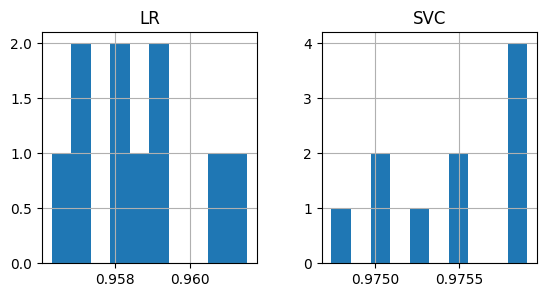

In [35]:
metrics.hist(layout = (1,3),figsize = (10,3))

<AxesSubplot: >

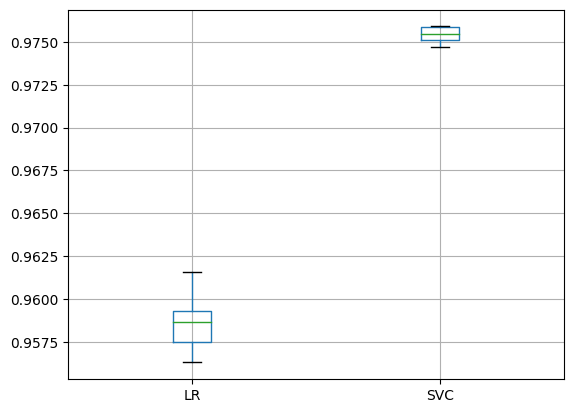

In [36]:
metrics.boxplot()

### SVC with Different Vectorizer: 
#### Counter vs Tfidf

Fscore metrics comparison

In [37]:
metrics = pd.DataFrame({'SVC_cvect':SVC_cvect['test_fscore_spam'], 'SVC_tfidf': SVC_tfidf['test_fscore_spam']})
metrics

,SVC_cvect,SVC_tfidf
0,0.975530,0.977358
1,0.974884,0.977297
2,0.975155,0.977255
3,0.974605,0.977922
4,0.975417,0.978035
5,0.975085,0.977391
6,0.975787,0.977547
7,0.975440,0.977097
8,0.975542,0.976841
9,0.975673,0.977980


array([[<AxesSubplot: title={'center': 'SVC_cvect'}>,
        <AxesSubplot: title={'center': 'SVC_tfidf'}>, <AxesSubplot: >]],
      dtype=object)

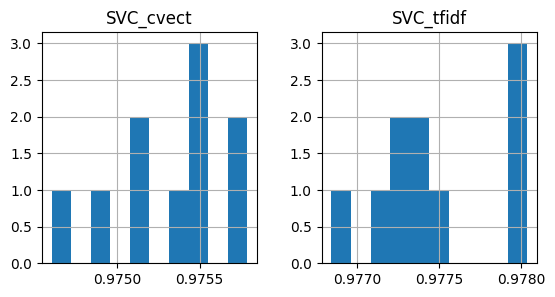

In [38]:
metrics.hist(layout = (1,3),figsize = (10,3))

<AxesSubplot: >

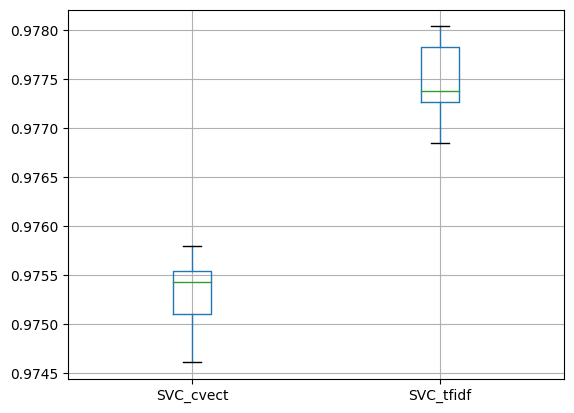

In [39]:
metrics.boxplot()

Accuracy metrics comparison

In [40]:
metrics = pd.DataFrame({'SVC_cvect':SVC_cvect['test_accuracy'], 'SVC_tfidf': SVC_tfidf['test_accuracy']})
metrics

,SVC_cvect,SVC_tfidf
0,0.975849,0.977662
1,0.975060,0.977457
2,0.975059,0.977164
3,0.974738,0.978042
4,0.975439,0.978071
5,0.975205,0.977515
6,0.975907,0.977661
7,0.975469,0.977135
8,0.975849,0.977135
9,0.975878,0.978188


array([[<AxesSubplot: title={'center': 'SVC_cvect'}>,
        <AxesSubplot: title={'center': 'SVC_tfidf'}>, <AxesSubplot: >]],
      dtype=object)

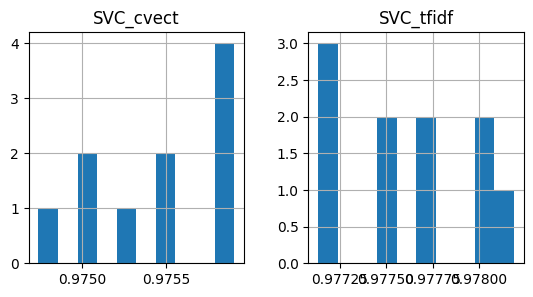

In [41]:
metrics.hist(layout = (1,3),figsize = (10,3))

<AxesSubplot: >

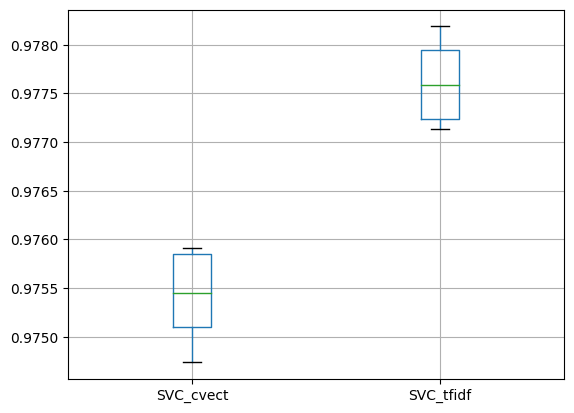

In [42]:
metrics.boxplot()